
BloomTech Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- Make at least 1 partial dependence plot to explain your model.
- Make at least 1 Shapley force plot to explain an individual prediction.

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- Make multiple PDPs with 1 feature in isolation.
- Make multiple PDPs with 2 features in interaction.
- Use Plotly to make a 3D PDP.
- Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- Use Shapley values to display verbal explanations of individual predictions.
- Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

## Business Scenario

Lending Club is an American lending marketplace that connects investors with borrowers. Instead of a bank or financial institution, investors act as lenders to fund borrowers loans.

Investors want to lend money to people who show a profile
of having a high probability of repayment. However, they face the challenge of predicting the risk of a borrower being unable to pay the loan back in full. They feel that the insights from existing data will help them in making data-driven decisions. So as data scientists, we will be building a model that can help in predicting whether a loan will not be paid back.

The dataset contains more than 9,500 loans with information about the borrower profile, loan structure and whether the loan was repaid. This data was extracted from [Kaggle - Loan Data](https://www.kaggle.com/datasets/itssuru/loan-data).

### Original Data Dictionary

|    | Variable          | Explanation                                                                                                             |
|---:|:------------------|:------------------------------------------------------------------------------------------------------------------------|
|  0 | credit_policy     | 1 if the customer meets the credit underwriting criteria; 0 otherwise.                                                  |
|  1 | purpose           | The purpose of the loan.                                                                                                |
|  2 | int_rate          | The interest rate of the loan (more risky borrowers are assigned higher interest rates).                                |
|  3 | installment       | The monthly installments owed by the borrower if the loan is funded.                                                    |
|  4 | log_annual_inc    | The natural log of the self-reported annual income of the borrower.                                                     |
|  5 | dti               | The debt-to-income ratio of the borrower (amount of debt divided by annual income).                                     |
|  6 | fico              | The FICO credit score of the borrower.                                                                                  |
|  7 | days_with_cr_line | The number of days the borrower has had a credit line.                                                                  |
|  8 | revol_bal         | The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle).                           |
|  9 | revol_util        | The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available). |
| 10 | inq_last_6mths    | The borrower's number of inquiries by creditors in the last 6 months.                                                   |
| 11 | delinq_2yrs       | The number of times the borrower had been 30+ days past due on a payment in the past 2 years.                           |
| 12 | pub_rec           | The borrower's number of derogatory public records.                                                                     |
| 13 | not_fully_paid    | 1 if the loan is not fully paid; 0 otherwise.   

In [1]:
!pip install pdpbox
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.7/572.7 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.0/570.0 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 11.5 MB/s eta 0:00:00
  Attempting uninstall: docutils
    Found existing installation: docutils 0.16
    Uninstalling docutils-0.16:
      Successfully uninstalled docutils-0.16
  Attempting uninstall: sphinx
    Found existing installation: Sphinx 3.5.4
    Uninstalling Sphinx-3.5.4:
      Successfully uninstalled Sphinx-3.5.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/

In [2]:
# Import Libraries

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from imblearn.over_sampling import SMOTE # to fix imbalance data
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import shap
from pdpbox import pdp

In [3]:
# Path to dataset
DATA_PATH = '/content/loan_data.csv'

## I. Wrangle Data

In [4]:
def wrangle(filepath):
  """
  This function performs data wrangling on the given dataset. It reads the dataset from the provided file path,
  replaces periods in column names with underscores, sets the data type of the 'purpose' column as category,
  handles outliers in the 'log_annual_inc' feature, performs feature engineering to create new columns,
  and drops the columns used for feature engineering to prevent data leakage.

  Parameters:
  - filepath (str): The file path of the dataset to be read.

  Returns:
  - loans (DataFrame): The cleaned and feature-engineered dataset.
  """
  loans = pd.read_csv(filepath)

  # Replacing period in column names with underscore
  loans.columns = loans.columns.str.replace(".", "_", regex=True)

  # Set data type of 'purpose' column as category
  loans['purpose'] = loans['purpose'].astype('category')

  # Outliers - Finding the upper and lower bounds for the log_annual_inc feature
  def find_outlier_limits(col_name):
      Q1,Q3=loans[col_name].quantile([.25,.75])
      IQR=Q3-Q1
      low=Q1-(1.5* IQR)
      high=Q3+(1.5* IQR)
      return (high,low)

  high_log_annual_inc, low_log_annual_inc = find_outlier_limits('log_annual_inc')

  # Replacing outlier values for log_annual_inc, and installment with respective upper and lower limits
  loans.loc[loans['log_annual_inc'] > high_log_annual_inc,'log_annual_inc'] = high_log_annual_inc
  loans.loc[loans['log_annual_inc'] < low_log_annual_inc,'log_annual_inc'] = low_log_annual_inc

  # Feature engineering
  loans['credit_score_cat'] = np.where(loans['fico'] >= 670, 'Good/Excellent', 'Fair/Poor')
  loans['multiple_hard_inq'] = np.where(loans['inq_last_6mths'] > 2, 1, 0)
  loans['cr_util_rate'] = loans['revol_util'].apply(lambda x: 1 if (x > 30 or x == 0) else 0)

  # To avoid data leakage let's drop the columns used to do feature engineering
  loans.drop(columns=['fico', 'inq_last_6mths', 'revol_util'], inplace=True)

  return loans

In [5]:
# Read data
loans = wrangle(DATA_PATH)

# Print a sample of the data
display(loans.sample(10))

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,days_with_cr_line,revol_bal,delinq_2yrs,pub_rec,not_fully_paid,credit_score_cat,multiple_hard_inq,cr_util_rate
4899,1,all_other,0.1287,319.52,11.918391,2.50,5069.958333,3267,0,0,0,Good/Excellent,0,0
1746,1,debt_consolidation,0.1505,693.83,11.277203,16.74,1440.000000,13596,0,0,0,Good/Excellent,0,1
1021,1,educational,0.1545,209.32,10.491274,24.03,2339.958333,6668,0,0,0,Fair/Poor,0,1
4202,1,debt_consolidation,0.1357,407.63,11.264464,23.72,4649.958333,28843,0,0,0,Good/Excellent,0,1
5489,1,major_purchase,0.1148,395.63,10.308953,2.80,5250.000000,8526,0,0,0,Good/Excellent,0,0
1128,1,credit_card,0.0945,128.04,9.903488,5.16,3180.000000,3621,0,0,0,Good/Excellent,0,0
3858,1,debt_consolidation,0.1126,262.91,11.415643,8.04,6300.000000,7670,0,0,0,Good/Excellent,0,1
3965,1,debt_consolidation,0.1253,284.47,11.147397,22.05,7020.000000,33321,0,0,0,Good/Excellent,0,1
7981,0,debt_consolidation,0.0996,257.99,9.903488,1.50,479.041667,358,0,0,0,Good/Excellent,0,0
8166,0,debt_consolidation,0.1457,516.83,10.817736,25.40,6360.041667,11937,0,0,1,Good/Excellent,0,1


## II. Split Data

Perform a random split with cross-validation on the training set for model evaluation. This provides a more robust evaluation by reducing the impact of any particular data split and gives a better estimate of the model's performance on unseen data.

In [6]:
# Split data into feature matrix and target vector
target = 'not_fully_paid'

y = loans[target] # target vector
X = loans.drop(columns=target) # feature matrix

In [7]:
# Randomly split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## III. Establish Baseline

The baseline refers to the score or performance that we would achieve by simply guessing or using a basic rule without any predictive modeling. It serves as a reference point to evaluate the effectiveness of our predictive models.

In [8]:
# Majority Class
print('Majority Class:', y_train.value_counts(normalize=True).idxmax())

Majority Class: 0


In [9]:
# Assuming y_train contains the true labels for the training set
baseline_guess = [0] * len(y_train)  # Assigning 0 (majority class) to all instances
baseline_f1_score = f1_score(y_train, baseline_guess)

print("Baseline F1-score:", baseline_f1_score)

Baseline F1-score: 0.0


In [10]:
print('Baseline accuracy', y_train.value_counts(normalize=True).max())

Baseline accuracy 0.8397285304098147


## IV. Build Model and Check Metrics

After training and tuning three different models, we observed that the XGBoost model showed the best performance for the task at hand. Therefore, we have chosen to proceed with using the XGBoost model for further analysis and predictions.

We are going to train the final model using the entire training set without cross-validation, and use this trained model to make predictions on the test set.

In [11]:
%%time
# Specify the column names for numeric and categorical columns
numeric_cols = ['credit_policy', 'int_rate', 'installment', 'log_annual_inc', 'dti', 'days_with_cr_line',
                'revol_bal', 'delinq_2yrs', 'pub_rec', 'multiple_hard_inq', 'cr_util_rate']
categorical_cols = ['purpose', 'credit_score_cat']

# Create the transformers for preprocessing
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

# Preprocess the training data
numeric_transformed = numeric_transformer.fit_transform(X_train[numeric_cols])
categorical_transformed = categorical_transformer.fit_transform(X_train[categorical_cols])
X_train_preprocessed = np.hstack((numeric_transformed, categorical_transformed.toarray()))

# Convert the NumPy array to a DataFrame
all_column_names = numeric_cols + list(categorical_transformer.get_feature_names_out(categorical_cols))
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=all_column_names)

# Apply SMOTE oversampling and RandomUnderSampler to the preprocessed training data
oversampler = SMOTE(random_state=42)
undersampler = RandomUnderSampler(random_state=42)
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train_preprocessed, y_train)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_oversampled, y_train_oversampled)


# Preprocess the test data
numeric_transformed_test = numeric_transformer.transform(X_test[numeric_cols])
categorical_transformed_test = categorical_transformer.transform(X_test[categorical_cols])
X_test_preprocessed = np.hstack((numeric_transformed_test, categorical_transformed_test.toarray()))
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=all_column_names)

# Create the XGBoost classifier with tuned hyperparameters
tuned_xgb_model = XGBClassifier(objective='multi:softmax',
                                num_class=len(np.unique(y_train)),
                                random_state=42,
                                n_estimators=100,
                                max_depth=5,
                                learning_rate=0.01)

# Fit the classifier on the resampled training data
tuned_xgb_model.fit(X_train_resampled, y_train_resampled)

# Predict on the preprocessed test set
y_pred = tuned_xgb_model.predict(X_test_preprocessed)

# Calculate the F1-score on the test set
f1 = f1_score(y_test, y_pred)

CPU times: user 24.5 s, sys: 125 ms, total: 24.7 s
Wall time: 29.3 s


In [12]:
# Print the F1-score
print('Test F1-score:', f1)

# Print the classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

Test F1-score: 0.32225063938618925
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.78      0.83      1611
           1       0.26      0.41      0.32       305

    accuracy                           0.72      1916
   macro avg       0.57      0.60      0.57      1916
weighted avg       0.78      0.72      0.75      1916



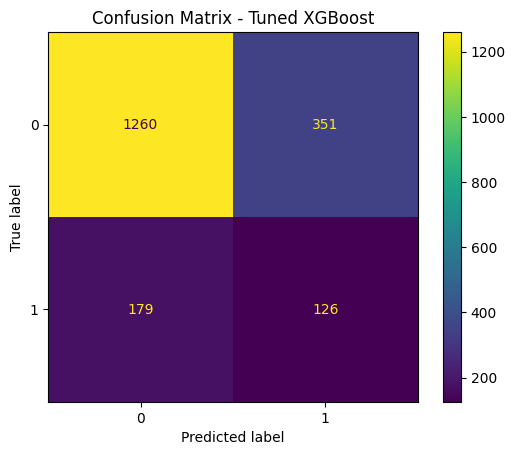

In [13]:
# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=tuned_xgb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tuned_xgb_model.classes_)
disp.plot()
plt.title('Confusion Matrix - Tuned XGBoost')
plt.show()

# VI. Communicate Results

Which features are most important to our model when making predictions?

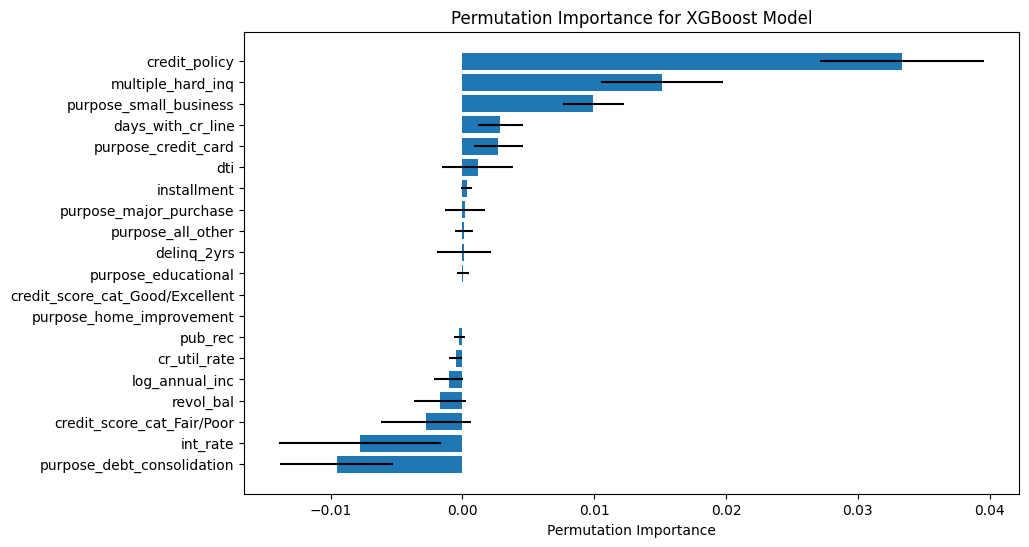

CPU times: user 5.93 s, sys: 73.6 ms, total: 6.01 s
Wall time: 6.85 s


In [14]:
%%time
# Calculate permutation importances
result = permutation_importance(tuned_xgb_model, X_test_preprocessed, y_test, n_repeats=10, random_state=42)

# Get feature names
feature_names = numeric_cols + list(categorical_transformer.get_feature_names_out(categorical_cols))

# Sort features based on their importance
sorted_idx = result.importances_mean.argsort()

# Plot permutation importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], xerr=result.importances_std[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance for XGBoost Model')
plt.show()


## PDP Isolate Plot

In [15]:
sample_feature = 'int_rate'

isolate = pdp.PDPIsolate(
    model=tuned_xgb_model,
    df=X_test_preprocessed_df,
    model_features=X_test_preprocessed_df.columns,
    feature=sample_feature,
    feature_name=sample_feature,
    n_jobs=-1,
    n_classes=2,
)

# Plot PDP Isolate
# Generate the PDP plot
pdp_fig_t, axes = isolate.plot()

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

In [16]:
# Display the plot
pdp_fig_t.show()

The figure above represents the Partial Dependence Plot (PDP) for the `int_rate` feature. Here are some insights we can get from the plot:

- The PDP line (blue line) shows the average response of the model as the `int_rate` feature changes. It indicates the relationship between the `int_rate` feature and the model's predicted outcome.

- The shaded area represents the uncertainty or variance in the model's response as the `int_rate` feature changes. It provides an indication of the level of confidence in the predictions.

- The dashed line represents the baseline or reference point. In this case, it is flat dashed line at 0, indicating that the baseline prediction is not influenced by the `int_rate` feature.

- The blue markers represent the individual instances or observations from the dataset and their corresponding predictions. It provides a visual representation of the relationship between the `int_rate` feature and the predicted outcomes.

The plot helps us understand how changes in the `int_rate` feature affect the model's predictions. It shows the average response as well as the variation in predictions based on different values of the `int_rate` feature.

If the interest rate increases, the predicted outcome (centered) also increases. But we can notice that it reaches a point where it becomes flat at around 0.25, suggesting that further increases in the interest rate have little to no effect on the predicted outcome. The relationship between the interest rate and the predicted outcome becomes less significant.

This behavior can be interpreted as an indication that beyond a certain interest rate, other factors or variables might have a stronger influence on the predicted outcome. It suggests that there is a limit to how much the outcome can be affected by changes in the interest rate alone.

### PDP Interact Plot

In [17]:
X_test_preprocessed_df.drop(columns='x', inplace=True)

In [18]:
#select two features
two_selected_features = ['int_rate','credit_policy']

# instantiate pdp_interact class

interact = pdp.PDPInteract(
    tuned_xgb_model,
    df=X_test_preprocessed_df,  # Provide your dataset here
    feature_names=two_selected_features,  # Specify the name of the features
    model_features=X_test_preprocessed_df.columns,
    features=two_selected_features,
    n_classes=2,
)

obtain pred_func from the provided model.


  0%|          | 0/10 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/2 [00:00<?, ?it/s]

obtain pred_func from the provided model.


  0%|          | 0/20 [00:00<?, ?it/s]

In [19]:
# Plot PDP interact plot
pdp_fig, axes = interact.plot(plot_type='grid')

In [20]:
# Display the image
pdp_fig.show()

1. X-axis: The 'int_rate' feature represents the interest rate of the loan.

2. Y-axis: The 'credit_policy' feature categorizes customers into two groups: 'credit_policy_0' and 'credit_policy_1'. 'credit_policy_1' typically represents customers who meet the credit underwriting criteria, while 'credit_policy_0' represents customers who do not meet the criteria.

3. It seems like higher interest rates are associated with a higher likelihood of customers not meeting the underwriting criteria and being classified as potential loan defaulters. This aligns with the general understanding that higher interest rates can lead to higher borrowing costs and potentially make it more challenging for borrowers to meet their loan obligations. However, the probability of meeting the credit underwriting criteria ('credit_policy_1') does not show a clear trend with changing interest rates, indicating that other factors may play a more significant role in determining creditworthiness.

### Shapley Plot

In [21]:
X_test_preprocessed_df.drop(columns='x', inplace=True)

In [22]:
X_test_preprocessed_df.iloc[150]

credit_policy                     -2.030187
int_rate                           1.005784
installment                        1.818253
log_annual_inc                     2.426533
dti                               -0.359408
days_with_cr_line                 -0.158490
revol_bal                         -0.083024
delinq_2yrs                        3.295587
pub_rec                           -0.239131
multiple_hard_inq                  1.890589
cr_util_rate                       0.648231
purpose_all_other                  0.000000
purpose_credit_card                0.000000
purpose_debt_consolidation         1.000000
purpose_educational                0.000000
purpose_home_improvement           0.000000
purpose_major_purchase             0.000000
purpose_small_business             0.000000
credit_score_cat_Fair/Poor         0.000000
credit_score_cat_Good/Excellent    1.000000
Name: 150, dtype: float64

In [23]:
# Create the explainer
shap_kernel_explainer = shap.KernelExplainer(tuned_xgb_model.predict_proba, shap.sample(X_test_preprocessed_df, 100), link='logit')

# Select a single row from the test data for which you want to compute SHAP values
sample_row_index = 150
sample_row = X_test_preprocessed_df.iloc[sample_row_index]

# Calculate SHAP values for the sample row
shap_values_single = shap_kernel_explainer.shap_values(sample_row)

# Plot the SHAP values for the sample row
shap.initjs()  # Required to display the plot in Jupyter Notebook
shap.force_plot(shap_kernel_explainer.expected_value[0], shap_values_single[0], sample_row, link='logit')


Let's analyze the SHAP plot for this new person who applied for a loan:

**Base value** = 0.64: There is a 64% chance that this person might have trouble paying back the loan.

**Red arrows (Risk-Increasing Factors):**

- credit_score_cat_Fair/Poor = 0: This person has a credit score category of "Fair/Poor," which increases the risk of loan default. Lower credit scores are generally associated with higher default risks.

- multiple_hard_inq = 1.891: This person has multiple hard inquiries on their credit report, which also increases the risk of loan default. Multiple hard inquiries might indicate that they have applied for several loans or credit accounts recently, potentially straining their financial situation.

- log_annual_inc = 2.427: The logarithm of the annual income for this person has a positive impact on the prediction, indicating that higher income is associated with a higher risk of loan default. This might seem counterintuitive, but it's important to remember that the model is based on patterns in the data it was trained on, which might not always reflect real-world causality. It could also potentially be related to their financial management and budgeting habits.

- purpose_debt_consolidation = 1: This person's loan purpose is debt consolidation, which for their case, increases the risk of loan default. Debt consolidation loans are often taken to pay off existing debts, and borrowers with higher levels of existing debt might be at a higher risk of defaulting.

- delinq_2yrs = 3.296: This person has a history of delinquencies in the past two years, which significantly increases the risk of loan default. Previous delinquencies suggest a pattern of late or missed payments, indicating potential financial instability.

**Blue arrows (Risk-Decreasing Factors):**

- int_rate = 1.006: The interest rate on this person's loan is associated with a decreased risk of default. Lower interest rates might make the loan more affordable and manageable for the borrower.

- credit_policy = -2.03: This person meets the credit policy requirements, which decreases the risk of loan default. Meeting the credit policy suggests that the borrower meets specific criteria set by the lender, indicating a higher likelihood of being a reliable borrower.

- purpose_credit_card = 0: Apparently the purpose of the loan for a credit card might have a neutral effect on the prediction.

This SHAP plot provides valuable insights into how the model is making predictions for this new loan applicant. It's important to consider all the factors together and remember that the model's output is based on the patterns in the training data, which might not always align perfectly with real-world scenarios. The SHAP plot helps us understand the risk factors that the model is identifying, but it does not provide explicit causal explanations for the predictions.

The lenders should always consider the model's output in the context of their domain knowledge and other relevant information when making decisions.